In [1]:
import torch
import pickle
import pandas as pd
import os
import numpy as np
import COSMO_TL as ctl
from dask.distributed import Client, LocalCluster, progress
import dask
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interpn
from scipy.interpolate import LinearNDInterpolator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.optimize import curve_fit, minimize, differential_evolution
# get particle swarm optimizer
from pyswarm import pso
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd

In [79]:


def get_X_solute(df):
    X = df[['volume_solute', 'area_solute', 'NC_K', 'SIGMA_K','TAU']]
    sig_cols = [col for col in df.columns if 'sigma_solute' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X_solvent(df):
    X = df[['volume_solvent', 'area_solvent','NC_K','SIGMA_K','TAU']]
    sig_cols = [col for col in df.columns if 'sigma_solvent' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X(df):
    X_solute = get_X_solute(df)
    X_solvent = get_X_solvent(df)
    # solvent prop cols = eps,n,alpha,beta,gamma,phi**2,psi**2,beta**2
    solvent_props_names = ['eps', 'n', 'alpha', 'beta', 'gamma', 'phi**2', 'psi**2', 'beta**2']
    solvent_props = df[solvent_props_names].to_numpy()
    X = np.column_stack((X_solute, X_solvent, solvent_props))
    return X
# given a dataframe return a dataframe with the mean value for all columns with error in the name
# grouped by SoluteName
def get_mean_df(df):
    df2 = df.copy()
    original_columns = list(df2.columns)
    print(original_columns)
    cols = [col for col in df2.columns if 'error' in col]
    original_columns = [col for col in original_columns if col not in cols]
    df3 = df2.groupby(['SoluteName', 'NC_K','SIGMA_K','TAU'])[cols].mean()
    df3 = df3.reset_index()
    # return a dataframe with the unique values in SoluteName and the mean values for all columns with error in the name
    # get all the other colums  from the original dataframe
    df4 = df2[original_columns]
    df4 = df4.reset_index(drop=True)
    df5 = pd.merge(df4, df3, on=['SoluteName', 'NC_K','SIGMA_K','TAU'])
    df5 = df5.drop_duplicates()
    return df5

In [80]:
df = pd.read_csv('../data/vaspsol_data_03_19_2023.csv')
print(len(df))
df['error'] = df['error'].abs()
df = df[df['error'] < 10]
df = df[df['Solvent'] == 'water']
df = df[df['Charge'] == 0]
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
default_df = df[(df['NC_K'] == NC_K_default) & (df['SIGMA_K'] == SIGMA_K_default) & (df['TAU'] == TAU_default)]
default_df

7911


,Unnamed: 0,Solvent,FileHandle,directory,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
54,54,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.076483,-76.381271,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,55,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063630,-76.330931,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,56,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063649,-76.330950,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,57,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063630,-76.330931,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,60,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063630,-76.330931,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,7019,water,n016,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.274200,-64.314735,2363,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7020,7020,water,n016,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.274198,-64.314733,2363,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7021,7021,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.138310,-129.040780,2187,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7022,7022,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.138300,-129.040770,2187,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
df_to_append = default_df[['SoluteName','error']]
# rename error to default_error
df_to_append = df_to_append.rename(columns={'error': 'default_error'})
df_to_append

,SoluteName,default_error
54,fluorobenzene,0.983698
55,fluorobenzene,0.687308
56,fluorobenzene,0.687746
57,fluorobenzene,0.687308
60,fluorobenzene,0.687308
...,...,...
7019,"1,2-ethanediamine",3.396948
7020,"1,2-ethanediamine",3.396994
7021,methylhexanoate,0.699429
7022,methylhexanoate,0.699198


In [82]:
# match up the default error back to the original dataframe
df = pd.merge(df, df_to_append, on=['SoluteName'])
# this expanded the number of rows in the dataframe. This is not what we want
df = df.drop_duplicates('Unnamed: 0')
default_df['default_error'] = default_df['error']
df

,Unnamed: 0,Solvent,FileHandle,directory,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,...,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,default_error
0,0,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.001000,0.200000,0.000670,0.073867,-76.193434,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
5,1,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002000,0.866667,0.000010,-0.200151,-76.467452,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
10,2,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.001000,1.200000,0.001000,-0.042744,-76.310045,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
15,3,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.001000,0.200000,0.001000,0.152467,-76.114834,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
20,4,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003000,0.533333,0.000340,-0.097007,-76.364308,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36539,7021,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002500,0.600000,0.000525,-0.138310,-129.040780,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429
36542,7022,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002500,0.600000,0.000525,-0.138300,-129.040770,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429
36545,7023,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003660,0.581300,0.000936,-0.125560,-129.028030,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429
36548,7024,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002500,0.600000,0.000525,-0.138300,-129.040770,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429


In [83]:
# how many unique values of NC_K, SIGMA_K, TAU are there?
df[['NC_K', 'SIGMA_K', 'TAU']].drop_duplicates()
print(len(df['NC_K'].unique())), print(len(df['SIGMA_K'].unique())), print(len(df['TAU'].unique()))
NC_K_opt = 0.003
SIGMA_K_opt = 0.64203644
TAU_opt = 0.0007722
df_opt = df[(df['NC_K'] == NC_K_opt) & (df['SIGMA_K'] == SIGMA_K_opt) & (df['TAU'] == TAU_opt)]
df_opt

454
433
443


,Unnamed: 0,Solvent,FileHandle,directory,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,...,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,default_error
290,58,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.061213,-76.328514,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
615,123,water,0169chl,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.047073,-30.669899,2249,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550778
1151,243,water,0151phy,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.457332,-98.549717,2237,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346444
1416,308,water,0198chl,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.115313,-22.649219,2268,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.751819
1672,372,water,0163chl,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.059260,-39.105335,2244,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36315,6941,water,0051cyc,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.164702,-88.967645,2140,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.088996
36336,6948,water,0147met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.218326,-74.987222,2233,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.061878
36358,6956,water,0409clb,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.038648,-72.192003,2317,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.103664
36387,6967,water,0408hex,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,0.006496,-30.425965,2316,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.263047


array([[<AxesSubplot: title={'center': 'error'}>,
        <AxesSubplot: title={'center': 'default_error'}>]], dtype=object)

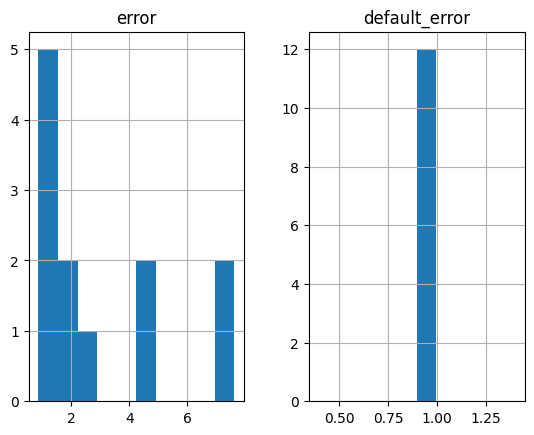

In [117]:
h2o = df[df['SoluteName'] == 'water']
# get row with min error   
h2o = h2o[h2o['error'] == h2o['error'].min()]
h2o[['NC_K', 'SIGMA_K', 'TAU', 'error', 'default_error']]
# show mean of h2o errors with NC_K, SIGMA_K, TAU from stats_df
df[(df['SoluteName'] == 'water') & (df['NC_K'].isin(stats_df['NC_K']))][['NC_K', 'SIGMA_K', 'TAU', 'error', 'default_error']].groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().hist()

In [84]:
n = 20
# get the lowest error for each solute, NC_K, SIGMA_K, TAU. this is will df2
df2 = df.groupby(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU'])['error'].min().reset_index()[['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error']]
# make sure each group has the same unique FileHandle. Use df2 to construct which FileHandles to include
df_grouped = df2.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get groups with at least 5 members
df_filtered = df_grouped.filter(lambda x: len(x) >= n)
df_filtered = df_filtered.reset_index(drop=True)
# # create a dataframe with the mean values for all the columns grouping by NC_K, SIGMA_K, TAU. Remove the SoluteName column. use get_level_values to get the unique values of NC_K, SIGMA_K, TAU
df_temp = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']].drop_duplicates()
# print the number of observations of each group
counts = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).count()['error']
# lets reset the df_temp dataframe to have a normal index and make the current indicies into columns
df_temp = df_temp.reset_index(drop=True)
# add the counts column to the dataframe
df_temp['counts'] = counts.values
# get the params of the minimum error
df_temp = df_temp.sort_values(by=['error'])
params_min = df_temp.iloc[0][['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
solutes_min = df[(df['NC_K'] == params_min[0]) & (df['SIGMA_K'] == params_min[1]) & (df['TAU'] == params_min[2])]['SoluteName'].unique()
# get the unique solutes in params_min and the info of params min
# first pretty print a table of params min 
print('NC_K: ', params_min[0], 'SIGMA_K: ', params_min[1], 'TAU: ', params_min[2])
print('error: ', df_temp.iloc[0]['error'], 'counts: ', df_temp.iloc[0]['counts'])
print('solutes: ', len(solutes_min))
# pretty print the number of solutes in solutes_min
params = df_temp[['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
# create a df containing the NC_K, SIGMA_K, TAU, and error for the minimum error. again filter to keep the minimum error for each group
dfs_temp = pd.concat([df[(df['NC_K'] == params[i][0]) & (df['SIGMA_K'] == params[i][1]) & (df['TAU'] == params[i][2])] for i in range(len(params))])
# keep only the solutes_min in dfs_temp
dfs_temp = dfs_temp[dfs_temp['SoluteName'].isin(solutes_min)]
# get the minimum error for each group of NC_K, SIGMA_K, TAU, and SoluteName
dfs_temp = dfs_temp.groupby(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU'])['error'].min().reset_index()[['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error']]
# group by NC_K, SIGMA_K, TAU to get the mean error for each group and add the counts column
# dfs_temp = dfs_temp.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']]
# dfs_temp['counts'] = counts.values
dfs_temp = dfs_temp.sort_values(by=['error'])
stats_df = pd.DataFrame()
dfs_temp_grouped = dfs_temp.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get all the params in the groups
stats_df['NC_K'] = dfs_temp_grouped['NC_K'].unique().apply(lambda x: x[0]).values
stats_df['SIGMA_K'] = dfs_temp_grouped['SIGMA_K'].unique().apply(lambda x: x[0]).values
stats_df['TAU'] = dfs_temp_grouped['TAU'].unique().apply(lambda x: x[0]).values
stats_df['mean_error'] = dfs_temp_grouped['error'].mean().values
stats_df['counts'] = dfs_temp_grouped['error'].count().values
stats_df

NC_K:  0.002997 SIGMA_K:  0.6482 TAU:  0.0008541
error:  1.091243323358137 counts:  215.0
solutes:  215


/tmp/ipykernel_31376/4123178203.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']].drop_duplicates()


,NC_K,SIGMA_K,TAU,mean_error,counts
0,0.002187,0.969400,0.000374,4.505097,43
1,0.002500,0.600000,0.000525,1.105785,215
2,0.002750,0.660000,0.000472,1.472828,198
3,0.002997,0.648200,0.000854,1.091243,215
4,0.003000,0.642036,0.000772,1.113240,166
5,0.003660,0.581300,0.000936,1.106072,210


0.00308742, 0.59155393, 0.00079023

In [85]:

groups = df[df['Solvent']=='water'].groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get the number of unique groups
# using the groups split of the dataframe so that unique combos of NC_K, SIGMA_K, and TAU are in each group
split = 0.99
# get the unique groups
groups = df.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get the indicies of the groups
indicies = [np.array(i) for i in groups.indices.values()]
# get the number of groups
num_groups = len(indicies)
# get the number of groups to use for training
num_train_groups = int(num_groups*split)
# get the indicies of the groups to use for training
train_indicies = np.random.choice(indicies, size=num_train_groups, replace=False)
train_indicies = np.concatenate(train_indicies.flatten())
# get the indicies of the groups to use for testing
test_indicies = np.array([i for i in np.concatenate(indicies) if i not in train_indicies])
train_df = df.iloc[train_indicies]
test_df = df.iloc[test_indicies]

X_train = get_X_solute(train_df)
X_test = get_X_solute(test_df)
y_train = train_df['error'].to_numpy()
y_test = test_df['error'].to_numpy()


# print out the shape of the training data and the training labels. Nice retro looking print statment
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
n_observations_train = X_train.shape[0]
n_features_train = X_train.shape[1]
n_observations_test = X_test.shape[0]
n_features_test = X_test.shape[1]

print('TRAINING SET DETAILS')
print(f'Number of observations: {n_observations_train}')
print(f'Number of features: {n_features_train}')

print('TESTING SET DETAILS')
print(f'Number of observations: {n_observations_test}')
print(f'Number of features: {n_features_test}')

X_train shape: (7012, 56), y_train shape: (7012,)
X_test shape: (14, 56), y_test shape: (14,)
TRAINING SET DETAILS
Number of observations: 7012
Number of features: 56
TESTING SET DETAILS
Number of observations: 14
Number of features: 56


/tmp/ipykernel_31376/22980259.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_indicies = np.random.choice(indicies, size=num_train_groups, replace=False)


In [86]:
# make a load_last() function to load the last saved model and the last saved scaler
def load_last():
    # look under .models for all the files
    files = [os.path.abspath('./models/'+i) for i in os.listdir('./models')]
    
    # find the last scaler saved using the key word 'scaler'
    last_scaler = max([i for i in files if 'scaler' in i], key=os.path.getctime)
    # the last model will have an identical name except 'scaler_' is not in the name
    last_model = last_scaler.replace('scaler_', '')
    print('loading model: ', last_model)
    print('loading scaler: ', last_scaler)
    model_file = last_model
    scaler_file = last_scaler
    layers = int(model_file.split('layers_')[1].split('_')[0])
    layer_size = int(model_file.split('layer_size_')[1].split('_')[0])
    n_inputs = int(model_file.split('n_inputs_')[1].split('_')[0])
    n_outputs = int(model_file.split('n_outputs_')[1].split('_')[0])
    loadmodel = ctl.model.NN(layers=layers, layer_size=layer_size, n_inputs=n_inputs, n_outputs=n_outputs)
    try:
        with open(model_file, 'rb') as f:
            state_dict = pickle.load(f)
            loadmodel.load_state_dict(state_dict)
    except:
        print('model not found')
    with open(scaler_file, 'rb') as f:
        scaler = pickle.load(f)
    return loadmodel, scaler
# test 
print(os.getcwd())
model, scaler = load_last()
model

/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_Benchmarks/VaspPysol/notebooks
loading model:  /blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_Benchmarks/VaspPysol/notebooks/models/layer_size_60_layers_2_n_inputs_56_n_outputs_1_19-03-2023_18-23-34.pkl
loading scaler:  /blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_Benchmarks/VaspPysol/notebooks/models/scaler_layer_size_60_layers_2_n_inputs_56_n_outputs_1_19-03-2023_18-23-34.pkl


NN(
  (fc1): Linear(in_features=56, out_features=60, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=60, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
  )
  (fout): Linear(in_features=60, out_features=1, bias=True)
)

In [87]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_pred = model(torch.from_numpy(X_train).float()).detach().numpy()
y_pred.shape, X_train.shape


((7012, 1), (7012, 56))

In [88]:
print(X_train.shape)
# send the training data to gpu
X_train = torch.from_numpy(X_train).float().reshape(-1, n_features_train)
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float().reshape(-1, n_features_train)
y_train.shape, X_train.shape


(7012, 56)


(torch.Size([7012, 1]), torch.Size([7012, 56]))

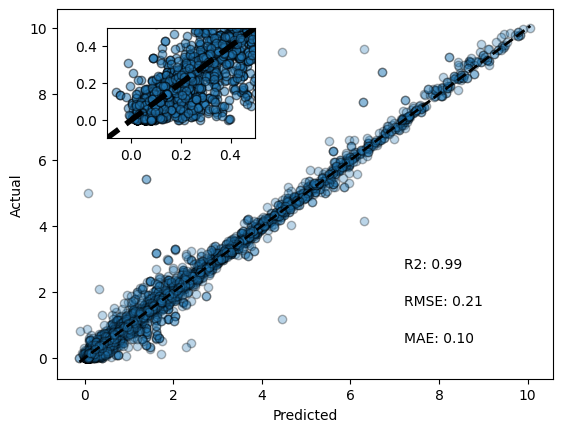

In [103]:
# plot the model against all the data 
# we will use the model to predict the y values for the training and testing data
#model = loadmodel
pred = model(X_train).cpu().detach().numpy()
# put the rmse, mse and r2 in the bottom left corner of the plot
mae = mean_absolute_error(y_train, pred)
rmse = np.sqrt(np.mean((pred - y_train.detach().cpu().numpy())**2))
r2 = r2_score(y_train, pred)
plt.text(0.7, 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)  
plt.text(0.7, 0.3, f'R2: {r2:.2f}', transform=plt.gca().transAxes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.scatter(pred, y_train, edgecolors='k', alpha=0.3)
plt.plot([pred.min(), pred.max()], [pred.min(), pred.max()], 'k--', lw=2)
# lets put an inset in the top left corner of the plot of this parity plot
# zoomed in between 0 and 0.5
ax = plt.gca()
axins = ax.inset_axes([0.1, 0.65, 0.3, 0.3])
axins.scatter(pred, y_train,  edgecolors='k', alpha=0.5)
axins.plot([pred.min(),pred.max()], [pred.min(),pred.max()], 'k--', lw=4)
axins.set_xlim(-0.1, 0.5)
axins.set_ylim(-0.1, 0.5)
plt.savefig('NN_parity_plot.png')

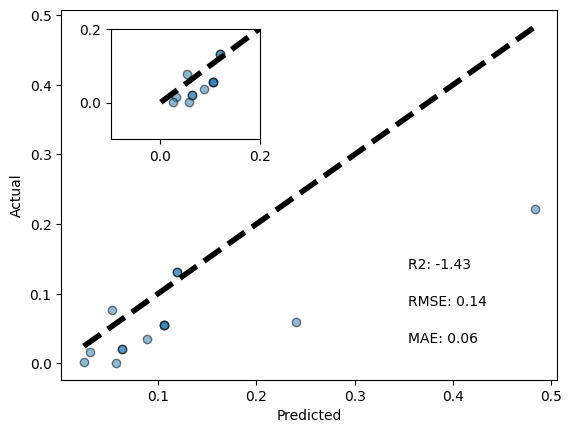

In [104]:
pred = model(X_test).cpu().detach().numpy()
# put the rmse, mse and r2 in the bottom left corner of the plot
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(np.mean((pred - y_test)**2))
r2 = r2_score(y_test, pred)
plt.text(0.7, 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)  
plt.text(0.7, 0.3, f'R2: {r2:.2f}', transform=plt.gca().transAxes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.scatter(pred, y_test, edgecolors='k', alpha=0.5)
plt.plot([pred.min(), pred.max()], [pred.min(), pred.max()], 'k--', lw=4)
# lets put an inset in the top left corner of the plot of this parity plot
# zoomed in between 0 and 0.5
ax = plt.gca()
axins = ax.inset_axes([0.1, 0.65, 0.3, 0.3])
axins.scatter(pred, y_test,  edgecolors='k', alpha=0.5)
axins.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axins.set_xlim(-0.1, 0.2)
axins.set_ylim(-0.1, 0.2)
plt.savefig('NN_parity_plot.png')

In [105]:
# create an optimizer object with inputs of NC_K, SIGMA_K, and TAU and will use defaultdf to compute the error
from scipy.optimize import minimize
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
def compute_error(inputs):
    NC_K = inputs[0]
    SIGMA_K = inputs[1]
    TAU = inputs[2]
    # replace the NC_K, SIGMA_K, and TAU columns with the new values
    df = default_df.copy()
    df['NC_K'] = NC_K
    df['SIGMA_K'] = SIGMA_K
    df['TAU'] = TAU
    X = get_X_solute(df)
    X = scaler.transform(X)
    X = torch.from_numpy(X).float().reshape(-1, n_features_train)
    pred = model(X).cpu().detach().numpy()
    return pred.mean()

# minimize the error given bounds on the inputs
res = minimize(compute_error, [NC_K_default, SIGMA_K_default, TAU_default], bounds=[(0.001, 0.005), (0, 2), (0.000001, 0.001)], tol=1e-10)
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.0909752
        x: [ 3.022e-03  6.000e-01  7.862e-04]
      nit: 7
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [95]:
# lets do a light particle swarm optimization
from pyswarm import pso
def compute_error(inputs):
    NC_K = inputs[0]
    SIGMA_K = inputs[1]
    TAU = inputs[2]
    EPS = 78.36
    # replace the NC_K, SIGMA_K, and TAU columns with the new values
    df = default_df.copy()
    df['NC_K'] = NC_K
    df['SIGMA_K'] = SIGMA_K
    df['TAU'] = TAU
    df['eps'] = EPS
    X = get_X_solute(df)
    X = scaler.transform(X)
    X = torch.from_numpy(X).float().reshape(-1, n_features_train)
    pred = model(X).cpu().detach().numpy()
    return pred.mean()
model = model.to('cpu')

# minimize the error given bounds on the inputs. use 4 workers to speed up the process and make sure to display the progress
res = pso(compute_error, [0.001, 0, 0.000001], [0.005, 1.5, 0.001], swarmsize=1000, maxiter=10, minstep=1e-10, minfunc=1e-10,debug=True)
res[0], res[1]

No constraints given.
New best for swarm at iteration 1: [1.00000000e-03 1.11134647e+00 6.73145411e-04] 0.847034752368927
Best after iteration 1: [1.00000000e-03 1.11134647e+00 6.73145411e-04] 0.847034752368927
New best for swarm at iteration 2: [1.00000000e-03 1.12789051e+00 6.63934423e-04] 0.8415161967277527
Best after iteration 2: [1.00000000e-03 1.12789051e+00 6.63934423e-04] 0.8415161967277527
Best after iteration 3: [1.00000000e-03 1.12789051e+00 6.63934423e-04] 0.8415161967277527
New best for swarm at iteration 4: [1.00234078e-03 1.11836136e+00 6.67924043e-04] 0.84134840965271
Best after iteration 4: [1.00234078e-03 1.11836136e+00 6.67924043e-04] 0.84134840965271
New best for swarm at iteration 5: [1.00000000e-03 1.12699998e+00 6.94802545e-04] 0.835170567035675
New best for swarm at iteration 5: [1.00000000e-03 1.14193068e+00 7.22842391e-04] 0.8317863345146179
Best after iteration 5: [1.00000000e-03 1.14193068e+00 7.22842391e-04] 0.8317863345146179
New best for swarm at iteratio

KeyboardInterrupt: 

TAU = 0.001
0.9773431420326233
0.002 0.2
0.9773431420326233
1.3885670727312565


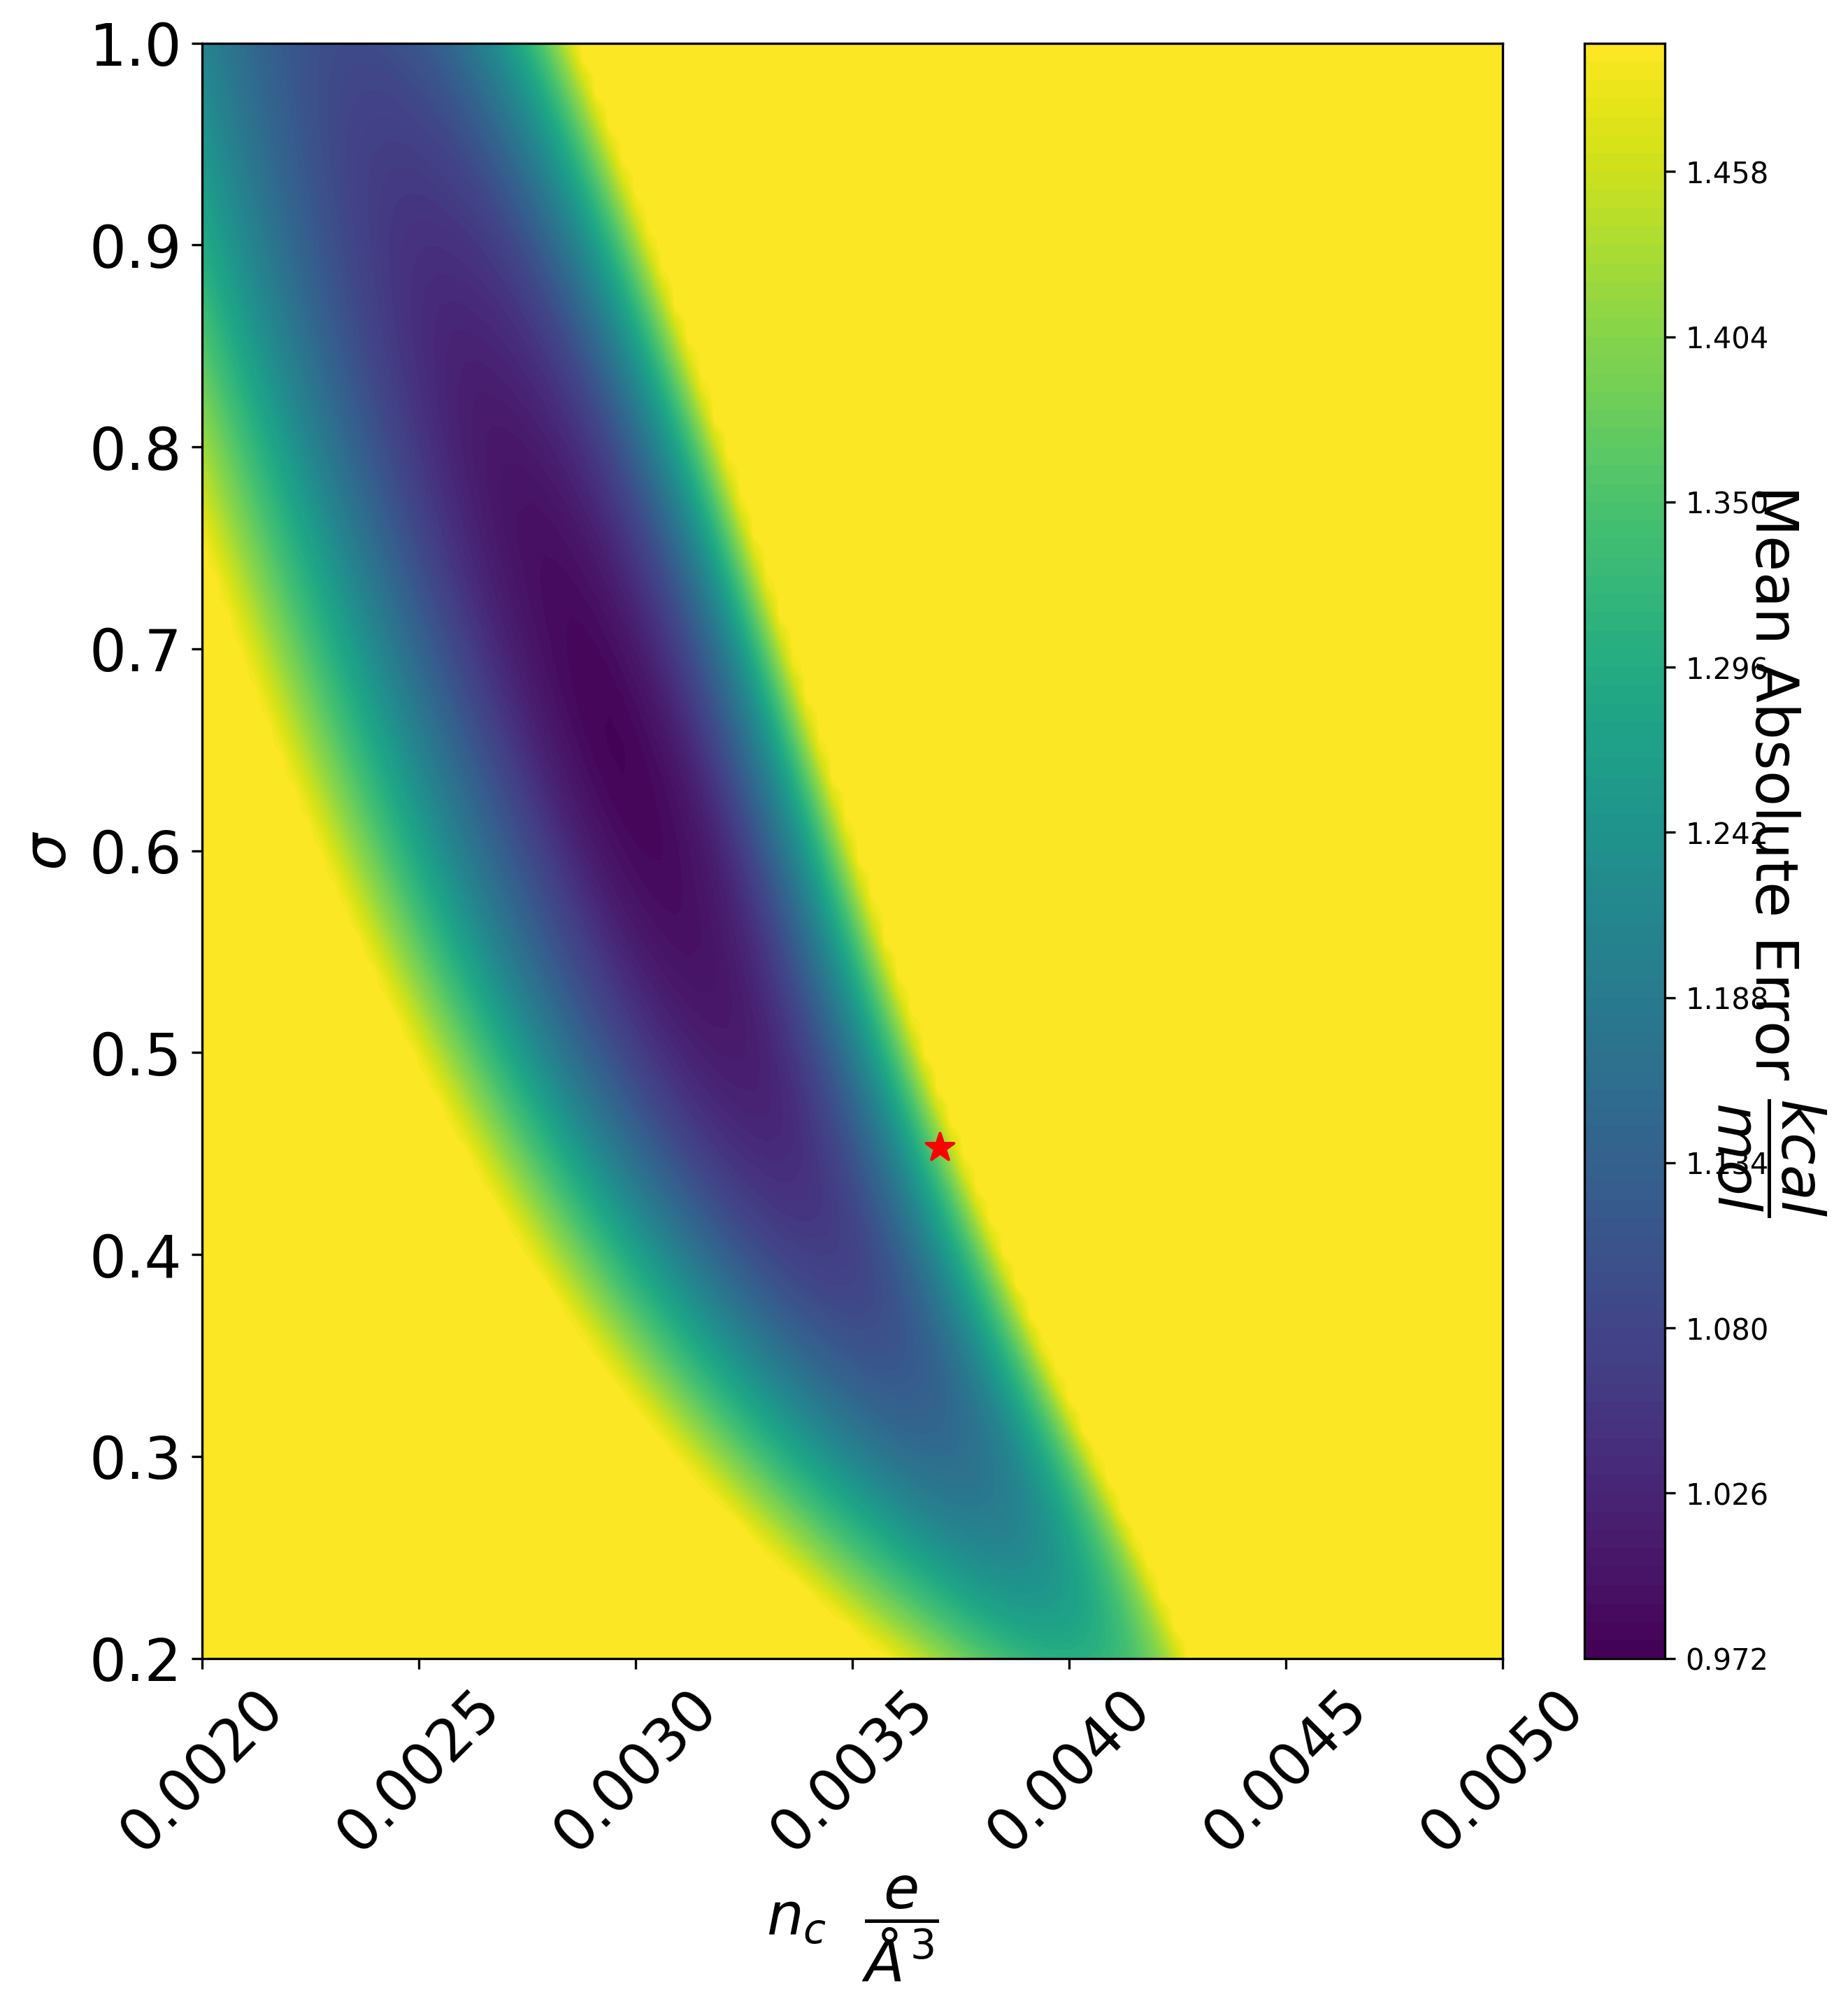

In [17]:

# use compute error to construc an error surface on NC_K and SIGMA_K using default TAU
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
NC_Ks = np.linspace(0.002, 0.005, 100)
SIGMA_Ks = np.linspace(0.2, 1.0, 100)
errors = np.zeros((len(NC_Ks), len(SIGMA_Ks)))
print('TAU = ' + str(res[0][2]))
for i, NC_K in enumerate(NC_Ks):
    for j, SIGMA_K in enumerate(SIGMA_Ks):
        errors[i, j] = compute_error([NC_K, SIGMA_K, res[0][2]])
        if errors[i, j] > 1.5:
            errors[i, j] = 1.5
plt.contourf(NC_Ks, SIGMA_Ks, errors, levels=100)
# make a colorbar
cbar = plt.colorbar()
cbar.set_label('Mean Absolute Error $\dfrac{kcal}{mol}}$', rotation=270, labelpad=20, fontsize=20)
# get the colors from the contour plot
colors = [plt.cm.jet(i) for i in np.linspace(0, 1, 100)]
# put a star at the minimum
plt.scatter(res[0][0], res[0][1], marker='*', color='red', s=100)
# rotate x axis labels 45 degrees
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$n_c$  $\dfrac{e}{\AA^3}$', fontsize=20)
plt.ylabel('$\sigma$ ', fontsize=20)



print(errors.min())
# where is the smallest error?
min_loc = np.where(errors == errors.min())
# print the NC_K and SIGMA_K values at the smallest error
print(NC_Ks[0], SIGMA_Ks[0])

# print min error
print(errors.min())
# print mean error
print(errors.mean())

